In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from matrix_neural_net import Network
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
# - clean up notebook, add comments
# - implement some feature engineering: 
#     - create maritial status from "Mr." or "Mrs." in title
#     - vectorize class?
# - scale age and fare categories
# - eventually ... 
#    - implement gridsearch for hyper-params 
#    - implement a genetic algorithm for hyper-params

In [2]:
class TqdmUpdate(tqdm):
     def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize


In [3]:
train_data = pd.read_csv('./data/titanic/train.csv')
test_data = pd.read_csv('./data/titanic/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Some notes: 
- Name is a string text, likely not helpful (although we may be able to use it to derive some info such as maritial status or professional status)
- Ticket is also a string text, unless we can figure out what 'A/' and 'PC' and 'STON' mean, likely not very helpful
- Cabin has a letter, this could indicate a class, possibly helpful, easy to convert to a numerical value
- Embarked is a single letter, also easy to convert to a numerical value

In [4]:
train_data.apply(pd.Series.isnull).sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# no missing data, convert to binary
train_data.Sex = train_data.Sex.map({'male': 0, 'female':1})
train_data.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [6]:
# 2 entries without Embarked. First lets see if its a usefull feature
train_data.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [7]:
# Check correlation with Surival
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [8]:
# replace all missing instances of embarked with S which is by the far the most popular category
train_data.Embarked.fillna(train_data['Embarked'].mode()[0], inplace=True)
train_data.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# Map values
train_data.Embarked = train_data.Embarked.map({'S':0, 'C':1, 'Q':2})
train_data.Embarked.value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [10]:
# Notice that class is a discrete variable [1, 3]
# Apply a transform to reframe this to a range [0, 2]
train_data['Pclass'].value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train_data.Pclass = train_data.Pclass.apply(lambda x : x-1)
train_data.Pclass.value_counts(dropna=False)

2    491
0    216
1    184
Name: Pclass, dtype: int64

In [12]:
train_data.apply(pd.Series.isnull).sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [13]:
# For missing data in Age:
# OPTION 1: drop all rows with missing data
#train_data.dropna(axis=0, how="any", inplace=True)
#train_data.reset_index(drop=True, inplace=True)
# OPTION 2: drop all columns with missing data (Age)
#train_data.dropna(axis=1, how="any", inplace=True)
# OPTION 3: replace missing values with a set value. 
# This will cause some noise, but hopefully the network will be able to deal with it. 
# Especially since age dosn't have a very strong correlation with survival rate
train_data.Age.fillna(train_data.Age.median(), inplace=True)

In [14]:
# Verify Age no longer contains any null values
train_data.Age.isnull().sum()

0

We now have to: 
1. Drop Cabin, Name, Ticket (eventually extract useful info from Name and Ticket)

In [15]:
# Now that we have converted Sex and Embarked columns to numerical 
# values, we are going to drop the columns that we don't want to 
# use: "Name", "Ticket", "Cabin", "PassengerId", "Age"
train_data = train_data[['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
train_data.head()

,Age,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,22.0,0,2,0,1,0,7.2500,0
1,38.0,1,0,1,1,0,71.2833,1
2,26.0,1,2,1,0,0,7.9250,0
3,35.0,1,0,1,1,0,53.1000,0
4,35.0,0,2,0,0,0,8.0500,0


In [16]:
train_data.apply(pd.Series.isnull).sum(axis=0)

Age         0
Survived    0
Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [17]:
for col in train_data.columns: 
    print (col)
    print (train_data[col].value_counts())
    print ("\n")

Age
28.00    202
24.00     30
22.00     27
18.00     26
19.00     25
        ... 
55.50      1
70.50      1
66.00      1
23.50      1
0.42       1
Name: Age, Length: 88, dtype: int64


Survived
0    549
1    342
Name: Survived, dtype: int64


Pclass
2    491
0    216
1    184
Name: Pclass, dtype: int64


Sex
0    577
1    314
Name: Sex, dtype: int64


SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64


Embarked
0    646
1    168
2     77
Name: Embarked, dtype: int64




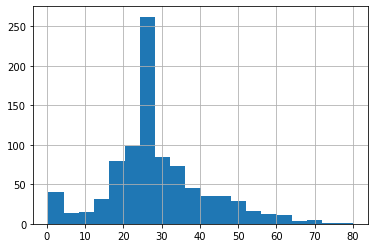

In [18]:
train_data.Age.hist(bins=20)

In [19]:
# Age generally follows a gaussian distribution. We will standardize it as follows:
mu, std = train_data.Age.describe()['mean'], train_data.Age.describe()['std']
train_data.Age = train_data.Age.apply(lambda x: (x-mu)/std)

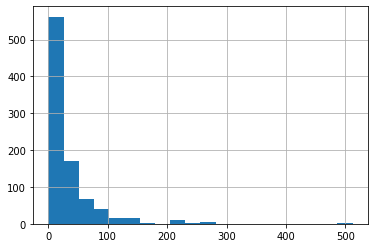

In [20]:
train_data.Fare.hist(bins=20)

In [21]:
# Fare, SibSp and Parch will be normalized using: x-min/(max-min)
for col in ['Fare', 'SibSp', 'Parch']:
    col_min, col_max = train_data[col].describe()['min'], train_data[col].describe()['max']
    train_data[col] = train_data[col].apply(lambda x: (x-col_min)/(col_max - col_min))
    

In [22]:
# Notice that Sex, Class and Fare have the strongest correlation with survival
train_data.corr()

,Age,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
Age,1.000000,-0.064910,-0.339898,-0.081163,-0.233296,-0.172482,0.096688,-0.009165
Survived,-0.064910,1.000000,-0.338481,0.543351,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.339898,-0.338481,1.000000,-0.131900,0.083081,0.018443,-0.549500,0.045702
Sex,-0.081163,0.543351,-0.131900,1.000000,0.114631,0.245489,0.182333,0.116569
SibSp,-0.233296,-0.035322,0.083081,0.114631,1.000000,0.414838,0.159651,-0.059961
Parch,-0.172482,0.081629,0.018443,0.245489,0.414838,1.000000,0.216225,-0.078665
Fare,0.096688,0.257307,-0.549500,0.182333,0.159651,0.216225,1.000000,0.062142
Embarked,-0.009165,0.106811,0.045702,0.116569,-0.059961,-0.078665,0.062142,1.000000


In [23]:
# More people perished than survived in our data set
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [24]:
# most basic model: always predict perish
# this method would have a success rate of ~60% 
# this will become the minimum accuracy for my 
# model to be considered functional. This will 
# also become of the accuracy of my model if 
# I encounter any vanishing/exploding gradient 
# issues
print ("%.2f%%" %(train_data['Survived'].value_counts()[0]/len(train_data)))

0.62%


In [25]:
# next step is to OHE discrete variables (sex is a discrete variable, but its binary, so we can leave it as is)
# These are: Pclass, Embarked

to_hot_encode =['Pclass', 'Embarked']
# calculate this one in order to avoid recalculating 
# unique values for each column
unique = { col: train_data[col].unique() for col in to_hot_encode }

def one_hot_encode(value, unique):
    ret = np.zeros(np.max(unique)+1)
    ret[value] = 1 # subt
    return list(ret)

def prep_input_vector(row):
    inp = list(row[['Age','Sex','Fare', 'Parch', 'SibSp']])
    
    for col in to_hot_encode:
        enc = one_hot_encode(int(row[[col]]), unique[col])
        inp.extend(enc)
    
    return inp

In [26]:
network_params = {
    'shape': [11, 8, 8, 2 ],
    'activation': 'tanh',
    'output_activation': 'sigmoid',
    'learning_rate': 0.01
}
network = Network(**network_params)
test_input = prep_input_vector(train_data.iloc[1])
print ("Original data: \n", train_data.iloc[1])
print ("Prepped for NN input: ", prep_input_vector(train_data.iloc[1]))

guess = network.forward_pass(test_input)
correct_value = train_data.loc[1, 'Survived']
print ("Network prediction: %s; expected: %i" % ( str(guess), correct_value))

expected_output = one_hot_encode(correct_value, [0,1])

# verity that the backwards pass works
network.backward_pass(
    network_input = test_input, 
    network_output = guess, 
    expected_output = expected_output
)

Original data: 
 Age         0.663488
Survived    1.000000
Pclass      0.000000
Sex         1.000000
SibSp       0.125000
Parch       0.000000
Fare        0.139136
Embarked    1.000000
Name: 1, dtype: float64
Prepped for NN input:  [0.663488390424261, 1.0, 0.13913573538264068, 0.0, 0.125, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Network prediction: [0.67606446 0.18153662]; expected: 1


In [70]:
# TODO: implement some sort of progress callback to keep track of training/testing progress
X = [prep_input_vector(train_data.iloc[i]) for i in train_data.index]
y = [one_hot_encode(train_data.loc[i, 'Survived'], [0,1]) for i in train_data.index]

network_params = {
    'shape': [11, 20, 40, 20, 2],
    'activation': 'tanh',
    'output_activation': 'sigmoid',
    'learning_rate': 0.1
}
network = Network(**network_params)

with TqdmUpdate() as t: 
    training_accuracy, testing_accuracy = network.train_test(X, y, test_split=0.2, progress=t.update_to)

print ("Train acc: %.4f - Test acc: %.4f" %(training_accuracy, testing_accuracy))

 99%|█████████▉| 177/178 [00:00<00:00, 943.76it/s] 

Train acc: 0.7560 - Test acc: 0.7416


 99%|█████████▉| 99/100 [00:17<00:00,  5.79it/s]


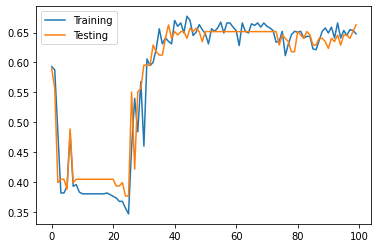

In [71]:
network = Network(**network_params)
with TqdmUpdate() as t: 
    training_accuracies, testing_accuracies = network.train_test_minibatch(
        X,y, test_split=0.2, batch_size=32, epochs=100, progress=t.update_to)
    
plt.plot(training_accuracies, label="Training")
plt.plot(testing_accuracies, label="Testing")
plt.legend()
plt.show()


In [30]:
shapes = [[11, 6, 1], [11, 12, 6, 1], [11, 24, 12, 1]]
activations = ['tanh', 'sigmoid', 'relu']
output_activations = ['sigmoid', 'relu']
learning_rates = [0.4, 0.1, 0.025]
possible_params = []
for shape in shapes:
    for activation in activations:
        for output_activation in output_activations: 
            for learning_rate in learning_rates:
                possible_params.append({
                    'shape': shape, 
                    'activation': activation,
                    'output_activation': output_activation,
                    'learning_rate': learning_rate
                })

In [31]:
# opt_ts = 0
# opt_params = {}
# for i in tnrange(len(possible_params)): 
#     params = possible_params[i]
#     tr, ts, _ = train_test(params, train_data, test_split=0.2)
#     if ts > opt_ts:
#         opt_ts = ts
#         opt_params = params
    

In [32]:
# print ("Optimal paramters", opt_params)
# print("Testing accuracy using above params: %.4f" % opt_ts)

In [33]:
# tr, ts, _ = kfold(opt_params, 10)
# print ("KFold validation - Training Accuracy: %.4f, Testing Accuracy: %.4f" %(tr, ts))